### HW 5: Build a many-to-one RNN for sentiment analysis

In this homework, you will build a many-to-one RNN for sentiment analysis, i.e., classify reviews into two categories: positive (1) and negative(0).

**Dataset**: 

    -IMDb Movie Reviews for binary sentiment classification
    -A set of 50,000 reviews with labels. All reviews have been cleaned.

In [1]:
#Feel free to import other necassary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader

from sklearn.metrics import classification_report, confusion_matrix

from tqdm import tqdm # you may need to install this package
tqdm.pandas()
from collections import Counter

#### 1. Load the dataset
In the my_imdb.csv file, the 'review' column has preprocessed texts of user reviews, and the 'label' has binary catogories. 1 indicates positive comments, and 0 means negative comments.

In [2]:
# read processed data
df = pd.read_csv('my_imdb-1.csv')
print(df.shape)
df.head()

(50000, 2)


,review,label
0,One reviewer mentioned watching Oz episode hoo...,1
1,A wonderful little production . The filming te...,1
2,I thought wonderful way spend time hot summer ...,1
3,Basically family little boy Jake think zombie ...,0
4,Petter Mattei Love Time Money visually stunnin...,1


#### 2. Text vectorization
Text vectorization converts texts into sequences of numeric values

- The **vocabulary** is a set that contains all unique words in the dataset.
- The **vectorizer** is dictionary that contains every word in the vocabulary set and its index
- The **padding** creates vectors with fixex length, e.g., 256
- Feel free to change the following code to use other text vectorization approaches, e.g., TF-IDF or BoW.

2.1 Create the vocabulary and the vectorizer

In [3]:
# get all words
text = df.review.values
words = ' '.join(text)
words = words.split() 

# build vocabulary
vocab = sorted(Counter(words), key=Counter(words).get, reverse=True)
ID2W = dict(enumerate(vocab, 1))
ID2W[0] = '<PAD>' # special word for paddding purpose, and the index is 0
vectorizer = {word: ID for ID, word in ID2W.items()}
vectorizer

{'.': 1,
 ',': 2,
 'I': 3,
 '-': 4,
 'movie': 5,
 'film': 6,
 'The': 7,
 'one': 8,
 '!': 9,
 'like': 10,
 'It': 11,
 '?': 12,
 'time': 13,
 'This': 14,
 'good': 15,
 'character': 16,
 'story': 17,
 'would': 18,
 'get': 19,
 'make': 20,
 'see': 21,
 'really': 22,
 'even': 23,
 'scene': 24,
 'much': 25,
 'well': 26,
 'people': 27,
 'bad': 28,
 'great': 29,
 'way': 30,
 'show': 31,
 'made': 32,
 'thing': 33,
 'first': 34,
 'also': 35,
 'could': 36,
 'think': 37,
 'life': 38,
 'But': 39,
 'know': 40,
 'go': 41,
 'And': 42,
 'plot': 43,
 'seen': 44,
 'actor': 45,
 'watch': 46,
 'A': 47,
 'say': 48,
 'year': 49,
 'love': 50,
 'many': 51,
 'end': 52,
 'two': 53,
 'acting': 54,
 'look': 55,
 'never': 56,
 'There': 57,
 'In': 58,
 'little': 59,
 'best': 60,
 'ever': 61,
 'better': 62,
 'work': 63,
 'If': 64,
 'take': 65,
 'come': 66,
 'He': 67,
 'find': 68,
 'man': 69,
 'part': 70,
 'still': 71,
 'something': 72,
 'want': 73,
 'give': 74,
 'back': 75,
 'lot': 76,
 'real': 77,
 'performance': 78

2.2 Sample results of vectorization

In [4]:
print('Text sample:', text[0])
num_vec = [vectorizer[w] for w in text[0].split()]
print('Coverted vector:',  len(num_vec), num_vec,)

Text sample: One reviewer mentioned watching Oz episode hooked . They right , exactly happened . The first thing struck Oz brutality unflinching scene violence , set right word GO . Trust , show faint hearted timid . This show pull punch regard drug , sex violence . Its hardcore , classic use word . It called OZ nickname given Oswald Maximum Security State Penitentary . It focus mainly Emerald City , experimental section prison cell glass front face inwards , privacy high agenda . Em City home many . . Aryans , Muslims , gangsta , Latinos , Christians , Italians , Irish . . . . scuffle , death stare , dodgy dealing shady agreement never far away . I would say main appeal show due fact go show dare . Forget pretty picture painted mainstream audience , forget charm , forget romance . . . OZ mess around . The first episode I ever saw struck nasty surreal , I say I ready , I watched , I developed taste Oz , got accustomed high level graphic violence . Not violence , injustice crooked guard

2.3 Apply vectorization to the whole dataset
- Apply padding to create sequences with fixed length
- The final dataset with with numeric features is (X, Y)

In [5]:
# text vectorization and padding
vecs = [[vectorizer[w] for w in r.split()] for r in tqdm(text)]
seq_length = 256
    
X = np.full((len(vecs), seq_length), 0, dtype=int)
for i, vec in enumerate(vecs):
    X[i, :len(vec)] = np.array(vec)[:seq_length]

print('Text vectors:', X.shape)
Y = df.label.to_numpy()
print('Labels:', Y.shape)

100%|██████████████████████████████████████████████████████████████████████████| 50000/50000 [00:05<00:00, 9435.75it/s]


Text vectors: (50000, 256)
Labels: (50000,)


In [6]:
print('Original vector:', vec[0])
print('Results with padding:', X[0])

Original vector: 291
Results with padding: [  191  1083   930    81  3724   186  3030     1   118   114     2   527
   500     1     7    34    33  3086  3724  5192 15234    24   490     2
   126   114   259  7473     1  5550     2    31  6620  2169 11285     1
    14    31   923  2106  2177   591     2   289   490     1   677  3805
     2   242   262   259     1    11   342  9227 10121   279 14927 22637
 12715  4100 55917     1    11   758  1332 29362  1094     2  4665  1963
  1105  2317  2079   822   243 55918     2 16586   237  4338     1 18349
  1094   261    51     1     1 25451     2  8327     2 12516     2 15235
     2  5060     2  7897     2  2344     1     1     1     1 22638     2
   251  4076     2  7347  1674  8574  9867    56   144   160     1     3
    18    48   193  1066    31   587    96    41    31  2759     1  4156
   106   281  4057  2373   166     2   798  1179     2   798   740     1
     1     1  9227   793   100     1     7    34   186     3    61   130
  3086  

#### 3. Prepare the training, validation and test sets. 15 points
- Use 50% data for training, 20% for validation, and 30% for testing
- Set the batch size to 128

In [7]:
from sklearn.model_selection import train_test_split

# Split the data into training, validation, and test sets
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.5, random_state=42)  # 50% train, 50% temp
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.6, random_state=42)  # 60% temp for test, 40% for validation

# Convert the data into torch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.long)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.long)

X_val_tensor = torch.tensor(X_val, dtype=torch.long)
Y_val_tensor = torch.tensor(Y_val, dtype=torch.long)

X_test_tensor = torch.tensor(X_test, dtype=torch.long)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.long)

# Create TensorDataset for each split
train_data = TensorDataset(X_train_tensor, Y_train_tensor)
val_data = TensorDataset(X_val_tensor, Y_val_tensor)
test_data = TensorDataset(X_test_tensor, Y_test_tensor)

# Set the batch size
batch_size = 128

# Create DataLoader for each dataset
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Verify the shape of data in DataLoader
for X_batch, Y_batch in train_loader:
    print("Training batch shape: ", X_batch.shape, Y_batch.shape)
    break


Training batch shape:  torch.Size([128, 256]) torch.Size([128])


#### 4. Build a many-to-one RNN. 40 points
- GRU or LSTM is preferred

In [8]:
# Define the LSTM model for many-to-one classification
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, seq_length):
        super(LSTMModel, self).__init__()
        
        # Embedding layer for converting word indices to vectors
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        
        # LSTM layer
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, batch_first=True)
        
        # Fully connected output layer
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        # Embedding lookup
        x = self.embedding(x)
        
        # Pass through LSTM layer
        lstm_out, (hidden, cell) = self.lstm(x)
        
        # We use the hidden state from the last time step for classification
        last_hidden = hidden[-1]  # Use the last hidden state (many-to-one)
        
        # Pass through the fully connected layer
        out = self.fc(last_hidden)
        
        return out

# Hyperparameters
embedding_dim = 100  # Size of word vectors
hidden_dim = 128  # Number of LSTM hidden units
output_dim = 2  # Binary classification (positive/negative)
seq_length = 256  # Sequence length (padded to this length)
vocab_size = len(ID2W) + 1  # Vocabulary size (including padding index)

# Initialize the model
model = LSTMModel(vocab_size=vocab_size, embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_dim=output_dim, seq_length=seq_length)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Suitable for classification problems
optimizer = Adam(model.parameters(), lr=0.001)

#### 5. Train the above model. 30 points

In [9]:
# Training loop
def train_model(model, train_loader, val_loader, epochs=10):
    for epoch in range(epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        correct = 0
        total = 0
        
        for X_batch, Y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch"):
            optimizer.zero_grad()  # Zero gradients before each step
            
            # Forward pass
            outputs = model(X_batch)
            
            # Calculate loss
            loss = criterion(outputs, Y_batch)
            running_loss += loss.item()
            
            # Backpropagation
            loss.backward()
            optimizer.step()
            
            # Prediction and accuracy
            _, predicted = torch.max(outputs, 1)
            total += Y_batch.size(0)
            correct += (predicted == Y_batch).sum().item()
        
        # Print training statistics
        train_accuracy = correct / total
        avg_train_loss = running_loss / len(train_loader)
        
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_train_loss:.4f}, Accuracy: {train_accuracy:.4f}")
        
        # Validation after every epoch
        val_accuracy = evaluate_model(model, val_loader)
        print(f"Validation Accuracy: {val_accuracy:.4f}")

#### 6. Calculate and report the performance of your model on the training and test set. 15 points
- Calcualte the accuracies on the training and test sets
- Print out the confusin matrix of model results on the test set: https://scikit-learn.org/dev/modules/generated/sklearn.metrics.confusion_matrix.html

Epoch 1/10: 100%|█████████████████████████████████████████████████████████████████| 196/196 [00:58<00:00,  3.34batch/s]


Epoch [1/10], Loss: 0.6025, Accuracy: 0.5957
Validation Accuracy: 0.5186


Epoch 2/10: 100%|█████████████████████████████████████████████████████████████████| 196/196 [00:53<00:00,  3.68batch/s]


Epoch [2/10], Loss: 0.5999, Accuracy: 0.5770
Validation Accuracy: 0.5155


Epoch 3/10: 100%|█████████████████████████████████████████████████████████████████| 196/196 [00:53<00:00,  3.69batch/s]


Epoch [3/10], Loss: 0.5910, Accuracy: 0.5790
Validation Accuracy: 0.5191


Epoch 4/10: 100%|█████████████████████████████████████████████████████████████████| 196/196 [00:51<00:00,  3.79batch/s]


Epoch [4/10], Loss: 0.5857, Accuracy: 0.5860
Validation Accuracy: 0.5213


Epoch 5/10: 100%|█████████████████████████████████████████████████████████████████| 196/196 [00:51<00:00,  3.79batch/s]


Epoch [5/10], Loss: 0.5791, Accuracy: 0.5887
Validation Accuracy: 0.5250


Epoch 6/10: 100%|█████████████████████████████████████████████████████████████████| 196/196 [00:50<00:00,  3.87batch/s]


Epoch [6/10], Loss: 0.5793, Accuracy: 0.5992
Validation Accuracy: 0.5208


Epoch 7/10: 100%|█████████████████████████████████████████████████████████████████| 196/196 [00:52<00:00,  3.71batch/s]


Epoch [7/10], Loss: 0.5687, Accuracy: 0.6029
Validation Accuracy: 0.5104


Epoch 8/10: 100%|█████████████████████████████████████████████████████████████████| 196/196 [00:51<00:00,  3.80batch/s]


Epoch [8/10], Loss: 0.5610, Accuracy: 0.6123
Validation Accuracy: 0.5296


Epoch 9/10: 100%|█████████████████████████████████████████████████████████████████| 196/196 [00:51<00:00,  3.82batch/s]


Epoch [9/10], Loss: 0.5522, Accuracy: 0.6255
Validation Accuracy: 0.5237


Epoch 10/10: 100%|████████████████████████████████████████████████████████████████| 196/196 [00:54<00:00,  3.60batch/s]


Epoch [10/10], Loss: 0.5425, Accuracy: 0.6388
Validation Accuracy: 0.5204


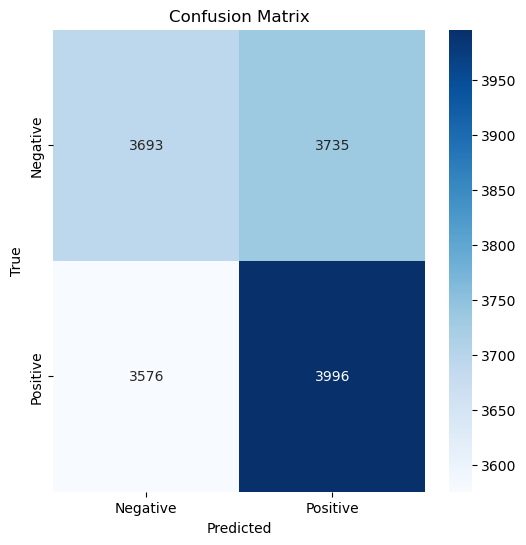

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Function to evaluate the model on validation/test set
def evaluate_model(model, data_loader):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    
    with torch.no_grad():  # No gradient computation for evaluation
        for X_batch, Y_batch in data_loader:
            outputs = model(X_batch)
            _, predicted = torch.max(outputs, 1)
            total += Y_batch.size(0)
            correct += (predicted == Y_batch).sum().item()
    
    accuracy = correct / total
    return accuracy

# Train the model
train_model(model, train_loader, val_loader, epochs=10)

# Function to compute and print confusion matrix
def print_confusion_matrix(model, test_loader):
    model.eval()  # Set model to evaluation mode
    all_labels = []
    all_preds = []
    
    with torch.no_grad():  # No need to compute gradients for inference
        for X_batch, Y_batch in test_loader:
            # Get model predictions
            outputs = model(X_batch)
            _, predicted = torch.max(outputs, 1)  # Get the class with the highest score
            
            all_labels.extend(Y_batch.numpy())  # Collect the true labels
            all_preds.extend(predicted.numpy())  # Collect the predicted labels
    
    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    # Plot confusion matrix using seaborn heatmap
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Print confusion matrix for test set
print_confusion_matrix(model, test_loader)
